In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy.sparse.construct import hstack
from sklearn.model_selection import ParameterGrid

In [2]:
import time
import operator
from collections import Counter

import xgboost as xgb
from xgboost import plot_tree
#import lightgbm as lgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name} done in {time.time() - start_time:.2f} s]')

In [3]:
train = pd.read_csv('data/complete_train.csv')
test = pd.read_csv('data/test.csv')
print(Counter(train['day']).keys())
print(Counter(test['day']).keys())

dict_keys([17, 18, 20, 21, 19, 22, 23, 24])
dict_keys([25, 24])


In [4]:
# sort data according to day and time
train = train.sort_values(by = ['day','time']).reset_index().iloc[:, 1:]
# convert hour to time slot
# is_midnight: 0, is_morning: 1, is_afternoon: 2, is_night: 3
def f(x):
    if x <= 7:
        return 0
    elif x > 7 and x <= 13:
        return 1
    elif x > 13 and x <= 19:
        return 2
    else:
        return 3
train['hour'] = train['hour'].apply(lambda x: f(x))
to_drop = ['is_morning','is_midnight','is_afternoon','is_night']
train= train.drop(to_drop, axis=1)

In [5]:
# delete some features
# check importance of features
exclude_features = ['instance_id','context_id', 'context_timestamp', 'is_trade','datetime', 'day', 'time','item_property_list']
df_train = train[(train['day'] >= 17) & (train['day'] <= 22)]
df_val = train[(train['day'] >= 23) & (train['day'] <= 24)]
y_train = df_train['is_trade']
x_train = df_train.drop(exclude_features, axis = 1)
y_val = df_val['is_trade']
x_val = df_val.drop(exclude_features, axis = 1)

In [6]:
def show_result(model, dtrain_x, dval_x, dtrain_y, dval_y ):
    y_pred_dtrain = model.predict_proba(dtrain_x)
    y_pred_val = model.predict_proba(dval_x)
    xgb_train_logloss = log_loss(dtrain_y, y_pred_dtrain)
    xgb_val_logloss = log_loss(dval_y, y_pred_val)
    plt.rcParams['figure.figsize'] = 12, 6
    fscore = pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False)
    fscore.plot(kind = 'bar',title = 'Feature Importance')
    plt.ylabel('Feature Importance Score')
    print("Logloss Score(Train): %f"%xgb_train_logloss)
    print("Logloss Score(Val): %f"%xgb_val_logloss)

In [7]:
xgboost2 = xgb.XGBClassifier(nthread = 25, learning_rate = 0.05, n_estimator = 500,
                           max_depth = 8, subsample = 0.7, colsample_bytree = 0.5,
                             min_child_weight = 10, seed = 123, objective = 'binary:logistic')

In [8]:
xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = 100)

[0]	validation_0-logloss:0.648132	validation_1-logloss:0.647774
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
[99]	validation_0-logloss:0.089176	validation_1-logloss:0.080206


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimator=500,
       n_estimators=100, n_jobs=1, nthread=25, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123, silent=True, subsample=0.7)

Logloss Score(Train): 0.089176
Logloss Score(Val): 0.080206


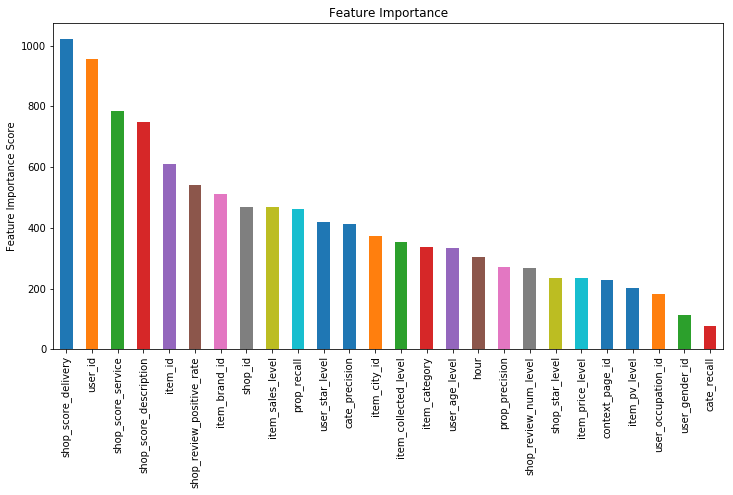

In [9]:
show_result(xgboost2, x_train, x_val, y_train, y_val)

In [10]:
t = {'n_estimator':99}
xgboost2.set_params(**t)
xgboost2.save_model('model/xgboost_26_start')

In [11]:
# Tune max_depth and min_child_weight
# 'max_depth':range(3,10,2),range(10,15,1)
# 'min_child_weight':range(10,12,1), range(9,14,1)
# 9,1,0.78386; 10,2,0.78381
# best max_depth = 9, min_child_weight = 13, best_logloss = 0.080095
grid1 = {
    'max_depth':range(9,10,1),
    'min_child_weight':range(13,14,1)
}
best_logloss = 0.080095
with timer('Tune max_depth and min_child_weight: '):
    for g in ParameterGrid(grid1):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('max_depth: ', xgboost2.get_params()['max_depth'])
            print('min_child_weight: ', xgboost2.get_params()['min_child_weight'])
            print('Minimal logloss', best_logloss)      

----------- -------------
logloss:  0.080095
[Tune max_depth and min_child_weight:  done in 130.78 s]


In [12]:
# Tune gamma [i/10.0 for i in range(0,5)]
# 'gamma': [0.31,0.32,0.33]
# best gamma = 0.31
t = {'n_estimator':99,'max_depth':9, 'min_child_weight': 13}
xgboost2.set_params(**t)

grid2 ={
    'gamma': [0.31]
}
best_logloss = 0.080081
with timer('Tune gamme: '):
    for g in ParameterGrid(grid2):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('gamma: ', xgboost2.get_params()['gamma'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.080081
[Tune gamme:  done in 129.01 s]


In [13]:
# Tune subsample and colsample_bytree
t = {'n_estimator':99,'max_depth':9, 'min_child_weight': 13,'gamma':0.31}
xgboost2.set_params(**t)

# 'subsample': [i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# 0.9; 0.81,0.82,0.83,0.84,0.85
# best subsample: 0.6, colsample_bytree: 0.9, best_logloss = 0.080009
grid3 ={
    'subsample': [0.60],
    'colsample_bytree':[0.90]
}
best_logloss = 0.080009
with timer('Tune subsample and colsample_bybree: '):
    for g in ParameterGrid(grid3):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('subsample: ', xgboost2.get_params()['subsample'])
            print('colsample_bytree: ', xgboost2.get_params()['colsample_bytree'])
            print('Minimal logloss', best_logloss)          

----------- -------------
logloss:  0.080009
[Tune subsample and colsample_bybree:  done in 181.41 s]


In [14]:
# Tuning Regularization Parameters
t = {'n_estimator':99,'max_depth':9, 'min_child_weight': 13,'gamma':0.31,
     'subsample':0.6, 'colsample_bytree': 0.9}
xgboost2.set_params(**t)
# Tune reg_alpha
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# 'reg_alpha':[0.0]
# best reg_alpha = 0
grid4 ={
    'reg_alpha':[0]
}
best_logloss = 0.080009
with timer('Tune reg_alpha: '):
    for g in ParameterGrid(grid4):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('reg_alphs: ', xgboost2.get_params()['reg_alpha'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.080009
[Tune reg_alpha:  done in 182.37 s]


In [15]:
# Tuning Regularization Parameters
t = {'n_estimator':99,'max_depth':9, 'min_child_weight': 13,'gamma':0.31,
     'subsample':0.6, 'colsample_bytree': 0.9,'reg_alpha':0}
xgboost2.set_params(**t)
# Tune reg_lambda
# 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
# 'reg_lambda':[0.1, 0.12, 0.13]
# 'reg_lambda':[0.05, 0.06, 0.07,0.88,0.89, 0.91, 0.92, 0.94, 0.96, 0.98,1.02,1.04, 1.06, 1.5]
# best reg_lambda = 0.1
grid5 ={
    'reg_lambda':[0.1]
}
best_logloss = 0.079905
with timer('Tune reg_lambda: '):
    for g in ParameterGrid(grid5):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('reg_lambda: ', xgboost2.get_params()['reg_lambda'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.079905
[Tune reg_lambda:  done in 258.29 s]


In [32]:
# Tuning scale_pos_weight
t = {'n_estimator':99,'max_depth':9, 'min_child_weight': 13,'gamma':0.31,
     'subsample':0.6, 'colsample_bytree': 0.9,'reg_alpha':0, 'reg_lambda':0.1}
xgboost2.set_params(**t)
# Tune scale_pos_weight
# 'scale_pos_weight':[0,0.1,0.11,0.12,0.2,0.5,0.7,0.8,0.9]
# 'scale_pos_weight':[0.55,0.6, 0.65,0.67,0.72]
# best logloss = 0.079235
# best scale_pos_weight: 0.71

grid6 ={
    'scale_pos_weight':[2,3,4,5,6]
}
# Tuning Regularization Parameters
best_logloss = 0.079235
with timer('Tune scale_pos_weight: '):
    for g in ParameterGrid(grid6):
        xgboost2.set_params(**g)
        print('----------- -------------')
        xgboost2.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=200, eval_metric='logloss', verbose = False)
        print('logloss: ',xgboost2.get_booster().best_score)
        if xgboost2.get_booster().best_score < best_logloss:
            best_logloss = xgboost2.get_booster().best_score
            print('Best so far!')
            print('scale_pos_weight: ', xgboost2.get_params()['scale_pos_weight'])
            print('Minimal logloss', best_logloss) 

----------- -------------
logloss:  0.087931
----------- -------------
logloss:  0.098676
----------- -------------
logloss:  0.110036
----------- -------------
logloss:  0.121857
----------- -------------
logloss:  0.133432
[Tune scale_pos_weight:  done in 1108.52 s]


In [18]:
t = {'scale_pos_weight':0.71, 'n_estimator':99,'max_depth':9, 'min_child_weight': 13,'gamma':0.31,
     'subsample':0.6, 'colsample_bytree': 0.9,'reg_alpha':0, 'reg_lambda':0.1}
xgboost2.set_params(**t)
xgboost2.save_model('model/xgboost_26_final')

Logloss Score(Train): 0.088472
Logloss Score(Val): 0.079235


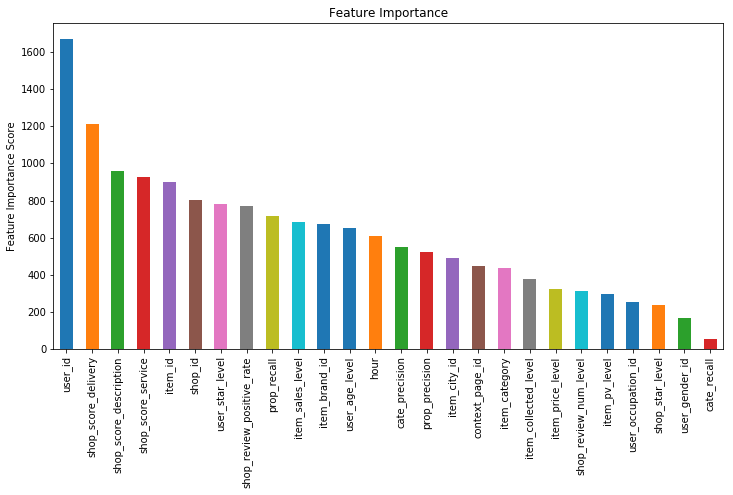

In [20]:
show_result(xgboost2, x_train, x_val, y_train, y_val)

In [22]:
# use xgboost to encode original features
x_train_leaves = xgboost2.apply(x_train)
x_val_leaves = xgboost2.apply(x_val)

In [23]:
all_leaves = np.concatenate((x_train_leaves, x_val_leaves),axis = 0)
all_leaves = all_leaves.astype(np.int32)

In [24]:
# one-hot encoding
xgbenc = OneHotEncoder()
all_trans = xgbenc.fit_transform(all_leaves)

In [25]:
(train_rows, cols) = x_train_leaves.shape

In [26]:
# LR with xgboost encoding features
lr = LogisticRegression()
lr.fit(all_trans[:train_rows,:],y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
y_pred_val_xgblr = lr.predict_proba(all_trans[train_rows:,:])
xgb_lr_logloss = log_loss(y_val, y_pred_val_xgblr)
print(xgb_lr_logloss)

0.11425288309507571


In [28]:
lr = LogisticRegression(n_jobs = -1)
# combine features
x_train_ext = hstack([all_trans[:train_rows,:],x_train])
x_val_ext = hstack([all_trans[train_rows:,:],x_val])

In [29]:
lr.fit(x_train_ext, y_train)

/Users/yuhe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_pred_val_xgblr2 = lr.predict_proba(x_val_ext)[:,1]
xgb_lr_logloss2 = log_loss(y_val, y_pred_val_xgblr2)
print(xgb_lr_logloss2)

0.08873298184524787
